# Look at pattern correlation between Hirabyashi et al. (2013) [H13] multi-model mean and our FULL experiment in the Phys-Streamflow paper
Figure out way to be quantitative about agreement to satisfy Reviewer 3 <br>
*Meg Fowler, 05-23-19*

In [1]:
# Load libraries
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import cartopy
from netCDF4 import Dataset


## Load in data

In [3]:
#Load lon and lat of CaMa data
CaMaFile = Dataset('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/fldare1161.nc')
lat =  CaMaFile.variables['lat'][:] 
lon = CaMaFile.variables['lon'][:] 

#Load in original return periods 
fullData = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/pyTfull.mat')
Tfull    = fullData['Tfull']

# Load significance data 
[hSigFull,hSigRad,hSigPhys]=np.load('/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/sig95.pkl')

#Apply boostrap significance to FULL return period to only consider significant gridcells
Tfull_sig = Tfull * hSigFull

#Load H13 data 
h13File = Dataset('/Users/meganfowler/gp_fuse/Flooding-physiology/H13_multimodel_median_100years_return_period_rcp85.nc')
latH = h13File.variables['lat'][:] 
lonH = h13File.variables['lon'][:] 
h13dat = h13File.variables['Band1'][:,:]


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


## Begin analyzing the two datasets together 

*First, let's look at some basic information about the two*

In [4]:
# On maps, only return periods greater than 2 years were counted, so let's knock out the others
Tfull_sig[np.where(Tfull_sig<=2)] = np.nan
h13dat[np.where(h13dat<=2)]       = np.nan


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until


*Make a few plots to make sure the data is what I expected*

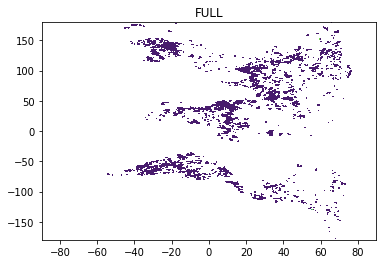

In [5]:
plt.contourf(lat,lon,Tfull_sig)
plt.title('FULL')
plt.show()

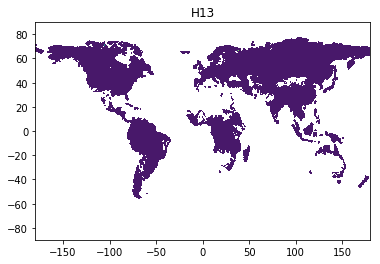

In [6]:
plt.contourf(lonH,latH,h13dat)
plt.title('H13')
plt.show()

*Now need to figure out a way to compare the two - what are some grid specs?*<br><br>

In [7]:
# How could we only consider places where FULL has data?
print('Shape of H13 data: ', np.shape(h13dat))
print('Shape of FULL data:', np.shape(Tfull_sig))
print()
print('lons [H13]: ', lonH[0:5])
print('lons [Full]:', lon[0:5])
print()
print('lats [H13]: ', latH[0:5])
print('lats [Full]:', lat[0:5])


Shape of H13 data:  (720, 1440)
Shape of FULL data: (1440, 720)

lons [H13]:  [-179.875 -179.625 -179.375 -179.125 -178.875]
lons [Full]: [-179.875 -179.625 -179.375 -179.125 -178.875]

lats [H13]:  [-89.875 -89.625 -89.375 -89.125 -88.875]
lats [Full]: [89.875 89.625 89.375 89.125 88.875]


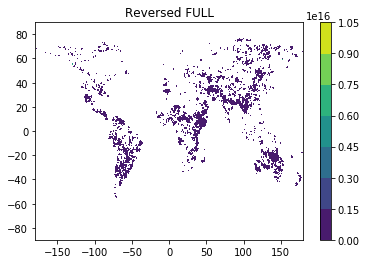

In [8]:
# Good news! The grids are the same, latitude is just reversed in FULL relative to H13. 
# So let's re-order FULL to be lon x lat, and flip lat array 

Tfull_trnsp = np.transpose(Tfull_sig)     #Re-order 
Tfull_revrs = np.flip(Tfull_trnsp,axis=0) #Flipping the latitude direction results in a totally reversed map relative to H13...

plt.contourf(lon,np.flip(lat,axis=0),Tfull_revrs)
plt.colorbar()
plt.title('Reversed FULL')
plt.show()


### Quantification attempts

**Attempt 1: Pattern Correlation**<br>
*Result*: The magnitudes are actually fairly different, which is actually in line with expectations. We discovered a large sensitivity of the magnitude to which extreme value distribution is chosen (GEV vs. Gumbel) and how it's computed, so magnitude isn't quite what we care about anyway. We are really only interested in the direction of change - does the 100-year flood control more or less often when CO2 is quadrupled?

In [10]:
# -- What does correlation look like? -- #

#Need to convert to 1d array for both... 
h13_select  = h13dat[np.where(np.isfinite(Tfull_revrs)==True)]       #Only include gridcells where FULL is defined
full_select = Tfull_revrs[np.where(np.isfinite(Tfull_revrs)==True)]
h13_select  = h13_select[np.where(np.isfinite(h13_select)==True)]    #Only include gridcells where H13 is defined 
full_select = full_select[np.where(np.isfinite(h13_select)==True)]

#Print out the correlation coefficient between the two... 
np.corrcoef(h13_select,full_select)  


array([[ 1.0000000e+00, -6.4294671e-05],
       [-6.4294671e-05,  1.0000000e+00]])

<br> 
Alright, so pattern correlations aren't going super great. Can we maybe at least say how many gridcells agree on an increase/decrease in flood frequency? 
<br><br>

**Attempt 2: Sign agreement**<br>
*Result*: This method shows good agreement between the two datasets. Though simplistic, the main concern is that the change in frequency - whether flooding increases or decreases - is consistent between the multi-model mean in H13 and in our own *FULL* experiment. This method checks to see if there's a match in the direction of change, and if there is, counts it as one. It turns out that more than 75% of gridcells agree!

In [11]:
# -- New approach... -- # 
match = np.full(np.shape(Tfull_revrs),np.nan)

countGT = 0
countLT = 0
countEq = 0 
countMiss = 0

for ilon in range(len(lon)):
    for ilat in range(len(lat)):
        fullPoint = Tfull_revrs[ilat,ilon]
        h13Point  = h13dat[ilat,ilon]
        
        if np.isfinite(fullPoint)==True and np.isfinite(h13Point)==True:
            if fullPoint>100 and h13Point>100: 
                match[ilat,ilon] = 1 
                countGT = countGT+1
            elif fullPoint<100 and h13Point<100:
                match[ilat,ilon] = 1 
                countLT = countLT+1
            elif fullPoint<=100.009 and h13Point>=100.000:
                match[ilat,ilon] = 1
                countEq = countEq+1
            else:
                countMiss = countMiss+1
                

In [12]:
print('---- Summary of matches ----')
print('numMatch: ', np.nansum(match))
print('pctMatch: ', np.nansum(match) / (np.nansum(match)+np.nansum(countMiss))*100, '%')
print()
print('Number that match with a decrease in return period:  ', countLT)
print('Number that match with an increase in return period: ', countGT)
print('Number that match with no change in return period:   ', countEq)

---- Summary of matches ----
numMatch:  14907.0
pctMatch:  78.30540526343437 %

Number that match with a decrease in return period:   11316
Number that match with an increase in return period:  1887
Number that match with no change in return period:    1704


**Attempt 3: Map Correlation (SPAEF)**<br>
*Result*: Found cool new metric online - SPAEF (https://github.com/cuneyd/spaef/blob/v1.0/spaef.py). See *Koch et al.* 2018 for more details.

In [9]:
from scipy.stats import variation,zscore

In [93]:
data = np.transpose(np.array([Tfull_revrs.flatten(),h13dat.flatten()]))
print(np.shape(data))
data = data[np.isfinite(data).all(1)]
np.shape(data)

(1036800, 2)


(19037, 2)

In [94]:
def filter_nan(s,o):
    data = np.transpose(np.array([s.flatten(),o.flatten()]))
    data = data[np.isfinite(data).all(1)]    #Modified to isfinite from isnan because of infinite values 
    return data[:,0], data[:,1]

In [95]:
def SPAEF(s, o, bins):
    #remove NANs    
    s,o = filter_nan(s,o)
    #compute ratio of CV
    alpha = variation(s)/variation(o)
    #compute zscore mean=0, std=1
    o=zscore(o)
    s=zscore(s)
    #compute histograms
    hobs,binobs = np.histogram(o,bins)
    hsim,binsim = np.histogram(s,bins)
    #convert int to float, critical conversion for the result
    hobs=np.float64(hobs)
    hsim=np.float64(hsim)
    #find the overlapping of two histogram      
    minima = np.minimum(hsim, hobs)
    #compute the fraction of intersection area to the observed histogram area, hist intersection/overlap index   
    hh = np.sum(minima)/np.sum(hobs)
    #compute corr coeff
    cc = np.corrcoef(s,o)[0,1]
    #compute SPAEF finally with three vital components
    spaef = 1- np.sqrt( (cc-1)**2 + (alpha-1)**2 + (hh-1)**2 )  

    return spaef, cc, alpha, hh

In [96]:
SPAEF(Tfull_revrs,h13dat,240)
#nbins = np.sqrt(np.size(np.where(np.isfinite(Tfull_revrs)==True)))

(-0.05193516977278101,
 -8.04622143273252e-05,
 0.6737996636041524,
 0.9998949414298471)